In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('train .csv')

In [3]:
df["TotalSpent"] = df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
df = df.astype({"TotalSpent": "float64"})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5282.0,32.397009,24.550326,0.00,9.0000,29.00,55.0000,72.00
MonthlySpending,5282.0,64.924754,30.176464,18.25,35.4625,70.40,90.0500,118.75
TotalSpent,5282.0,2287.486161,2269.049195,0.00,395.7250,1405.65,3795.2125,8684.80
IsSeniorCitizen,5282.0,0.159409,0.366092,0.00,0.0000,0.00,0.0000,1.00
Churn,5282.0,0.262022,0.439776,0.00,0.0000,0.00,1.0000,1.00


In [6]:
translations = {}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

In [7]:
def churn_by_category(category):
    df.groupby(['Churn', category]).size().unstack(fill_value=0).plot(kind='bar', stacked=True);

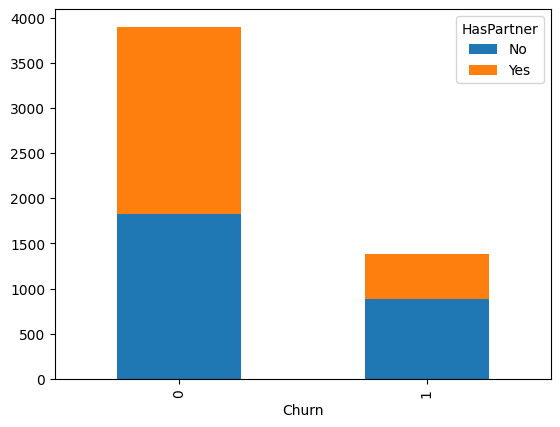

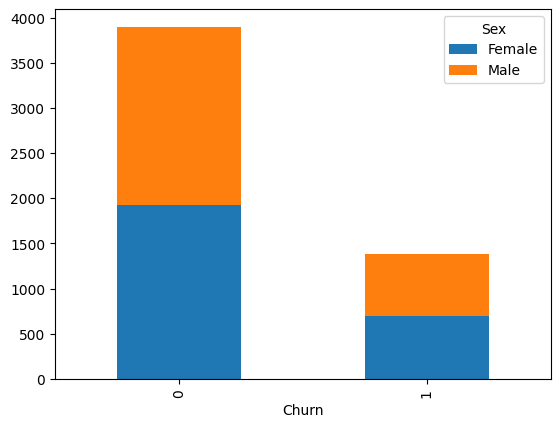

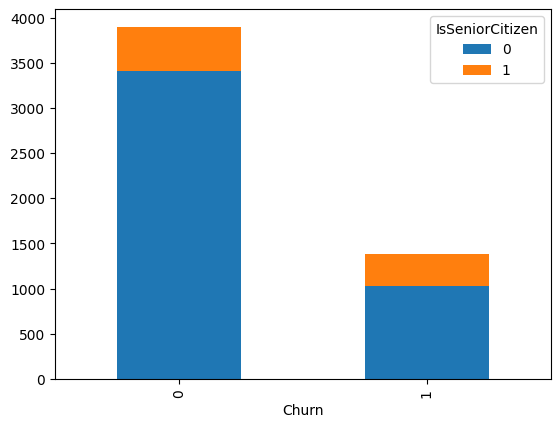

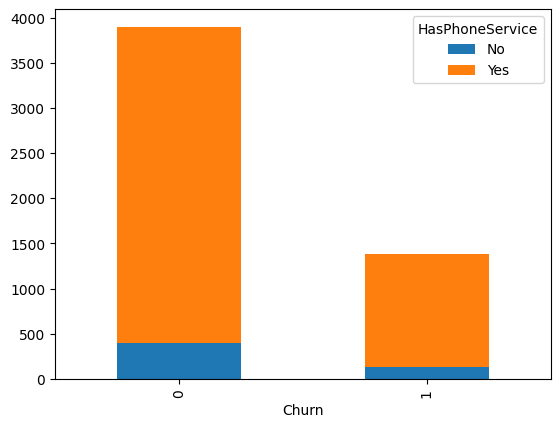

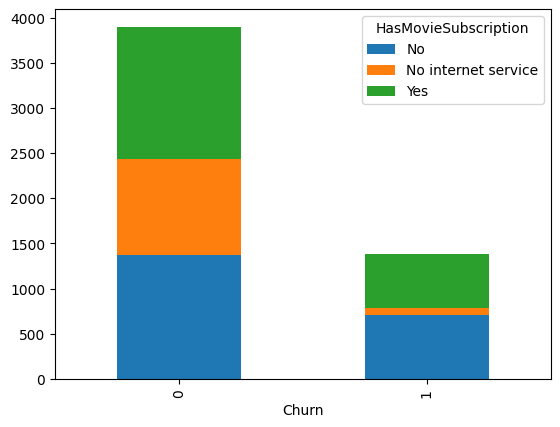

In [8]:
churn_by_category('HasPartner')
churn_by_category('Sex')
churn_by_category('IsSeniorCitizen')
churn_by_category('HasPhoneService')
churn_by_category('HasMovieSubscription')

Колонки HasPartner, Sex, IsSeniorCitizen, HasPhoneService, HasMovieSubscription не влияют на отток.
Удаление столбцов приводит к росту метрики.

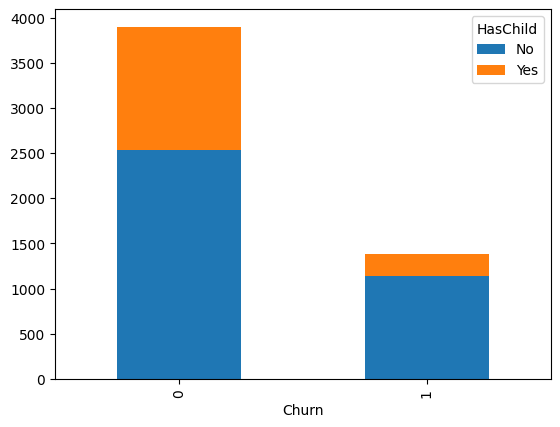

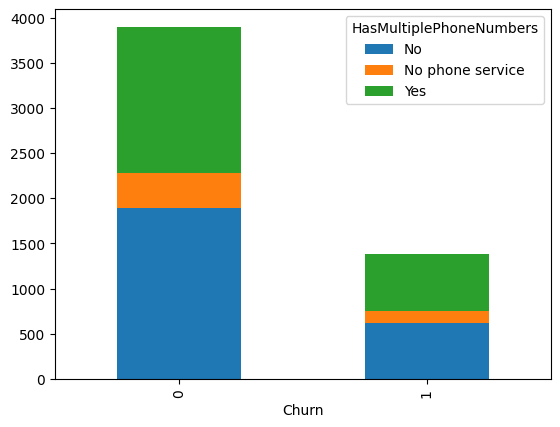

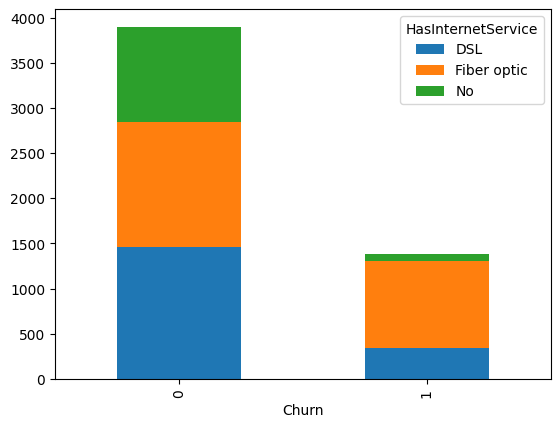

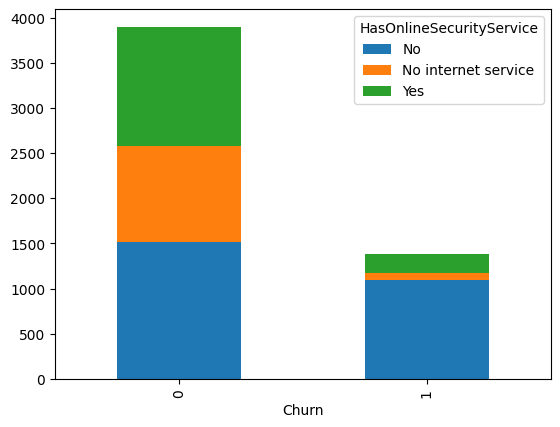

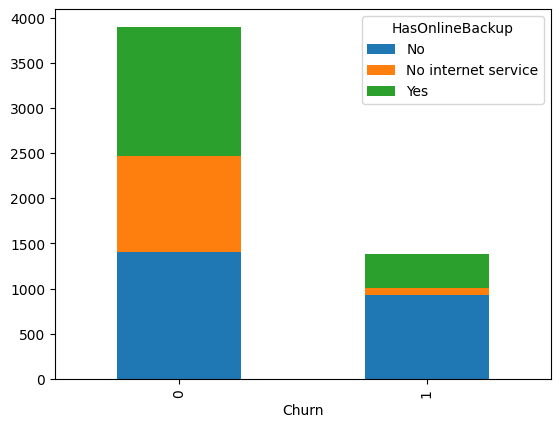

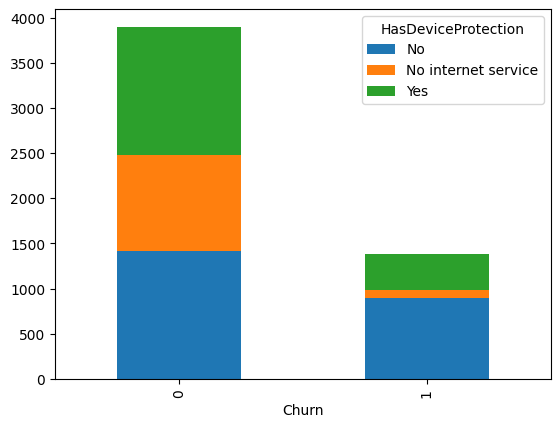

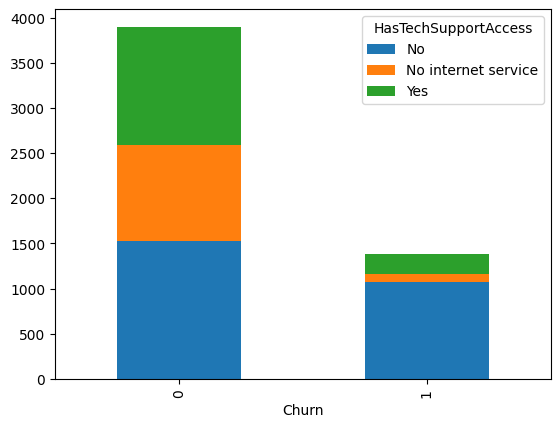

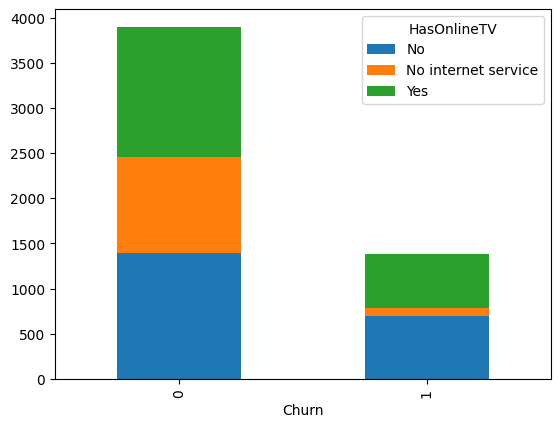

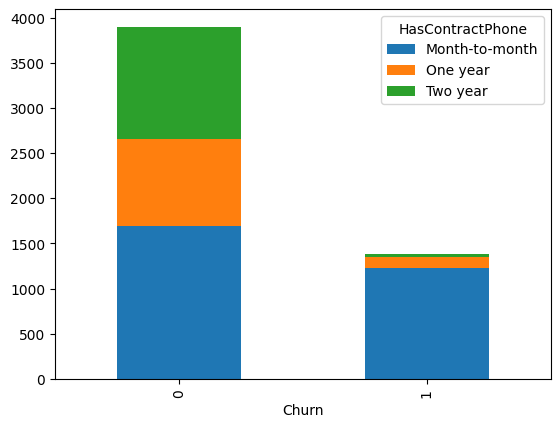

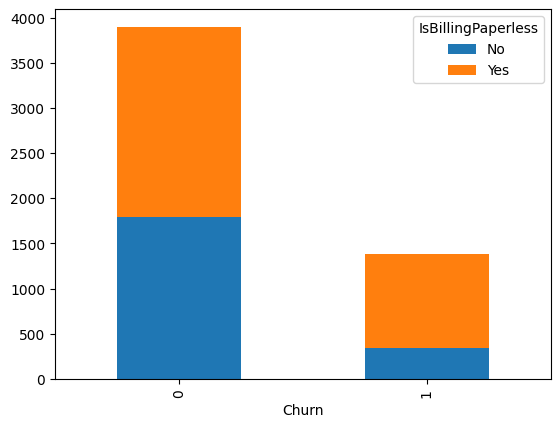

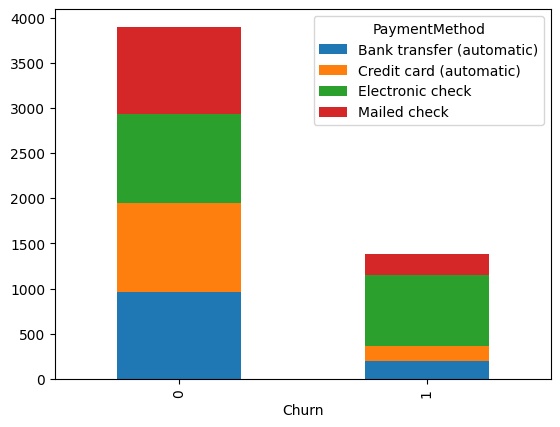

In [9]:
categorical_cols = [
    'HasChild',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod',
]

for col in categorical_cols:
    churn_by_category(col)

Колонки categorical_cols повышают метрику на 4%

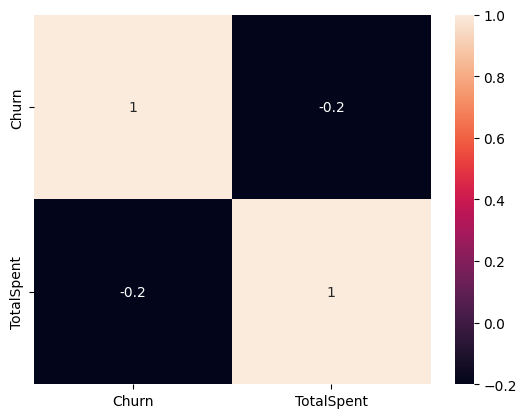

In [10]:
sns.heatmap(df[["Churn", "TotalSpent"]].corr(), annot=True);

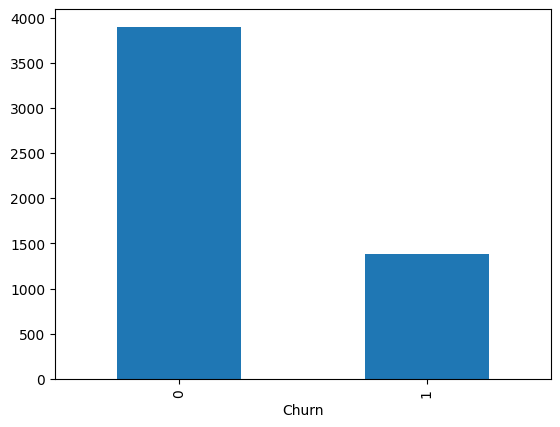

In [11]:
df["Churn"].value_counts().plot(kind="bar");

In [12]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.737978
1    0.262022
Name: proportion, dtype: float64

In [13]:
df = pd.get_dummies(df, columns=categorical_cols)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([
        "Churn",
        "Sex",
        "IsSeniorCitizen",
        "HasPartner",
        "HasPhoneService",
        'HasMovieSubscription',
    ], axis=1),
    df["Churn"],
    test_size=0.2,
    random_state=79,
    shuffle=True,
    stratify=df["Churn"],
)

In [15]:
lr = LogisticRegression(random_state=79, penalty=None, max_iter=10000)

In [16]:
# scaler_list = [
#     None,
#     MinMaxScaler(),
#     StandardScaler(),
#     RobustScaler(),
#     PowerTransformer(),
#     QuantileTransformer(random_state=0),
#     QuantileTransformer(random_state=0, output_distribution='normal'),
# ]
# pipeline = Pipeline([
#     ('scaler', StandardScaler()), # масштабирование
#     ('poly', PolynomialFeatures(interaction_only=True, degree=3, include_bias=False)),
#     ('model', lr),
# ])
# params = {
#     "scaler": scaler_list,
# }

# gs = GridSearchCV(
#     pipeline,
#     params,
#     cv=4,
#     scoring='roc_auc',
#     n_jobs=-1,
# )
# gs.fit(X_train, y_train)
# prediction = gs.predict_proba(X_test)
# roc_auc_score(y_test, prediction[:, 1])

In [17]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=79)

In [18]:
y_probs = lr.predict_proba(X_test)

In [19]:
y_probs = y_probs[:, 1]

In [20]:
roc_auc_score(y_test, y_probs)

0.8382069795427196

0.8382069795427196

In [21]:
dtc = DecisionTreeClassifier(random_state=79)

In [22]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=79)

In [23]:
pred = dtc.predict_proba(X_test)

In [24]:
roc_auc_score(y_test, pred[:, 1])

0.6241599555678978

In [25]:
rfc = RandomForestClassifier()

In [26]:
params = {
    "criterion": ["entropy", "gini"],
    "max_depth": range(3, 10),
    "n_estimators": range(3, 12),
}
gs = GridSearchCV(rfc, params, cv=4, scoring="roc_auc")

In [27]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(3, 10),
                         'n_estimators': range(3, 12)},
             scoring='roc_auc')

In [28]:
pred = gs.predict_proba(X_test)

In [29]:
roc_auc_score(y_test, pred[:, 1])

0.8365037489586227

In [30]:
etc = ExtraTreesClassifier()

In [31]:
gs = GridSearchCV(etc, params, cv=4, scoring="roc_auc")

In [32]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(3, 10),
                         'n_estimators': range(3, 12)},
             scoring='roc_auc')

In [33]:
pred = gs.predict_proba(X_test)

In [34]:
roc_auc_score(y_test, pred[:, 1])

0.8269161344071091

In [35]:
test_df = pd.read_csv('test.csv')
test_df["TotalSpent"] = test_df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
test_df = test_df.astype({"TotalSpent": "float64"})
test_df = pd.get_dummies(test_df, columns=categorical_cols)

In [36]:
sub_pred = lr.predict_proba(test_df)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- HasMovieSubscription
- HasPartner
- HasPhoneService
- IsSeniorCitizen
- Sex


In [ ]:
sub_pred[:, 1]

In [ ]:
sub_df = pd.DataFrame(sub_pred[:, 1], columns=['Churn'])

In [ ]:
sub_df.index.name = "Id"

In [ ]:
sub_df

In [ ]:
sub_df.to_csv("submission.csv")